In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
import seaborn as sns
import pandas as pd
import sys
import math

import matplotlib
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'
matplotlib.rcParams['mathtext.it'] = 'Times New Roman:italic'
matplotlib.rcParams['mathtext.bf'] = 'Times New Roman:bold'

### Definitions

In [3]:
# Main model as published in https://doi.org/10.1002/qute.202400409 

def coupled_SPDC_dEz_dz_dPsi_dz(z, Ez_Psi, C1, C2, C3, gamma, del_beta, del_phi):
    Ez = Ez_Psi[:n_wg]
    Psi = Ez_Psi[-n_wg**n_photon:]

    dEz_dz = [0j] * n_wg
    dPsi_dz = [0j] * (n_wg**n_photon)
    
    # dPsi_dz[0] = 1j * C * (Psi[1] + Psi[2] + Psi[4]) + 1j * Psi[0] * del_phi + gamma * Ez[0] * np.exp(1j * del_beta * z)
    dPsi_dz[0] = 1j * (C1 * Psi[2] + C2 * Psi[1] + C3 * Psi[4]) + 1j * Psi[0] * del_phi + gamma * Ez_Psi0[0] * np.exp(1j * del_beta * z)
    dPsi_dz[1] = 1j * (C1 * Psi[3] + C2 * Psi[0] + C3 * Psi[5]) + 1j * Psi[1] * del_phi
    dPsi_dz[2] = 1j * (C1 * Psi[0] + C2 * Psi[3] + C3 * Psi[6]) + 1j * Psi[2] * del_phi
    dPsi_dz[3] = 1j * (C1 * Psi[1] + C2 * Psi[2] + C3 * Psi[7]) + 1j * Psi[3] * del_phi
    dPsi_dz[4] = 1j * (C1 * Psi[6] + C2 * Psi[5] + C3 * Psi[0]) + 1j * Psi[4] * del_phi
    dPsi_dz[5] = 1j * (C1 * Psi[7] + C2 * Psi[4] + C3 * Psi[1]) + 1j * Psi[5] * del_phi
    dPsi_dz[6] = 1j * (C1 * Psi[4] + C2 * Psi[7] + C3 * Psi[2]) + 1j * Psi[6] * del_phi
    # dPsi_dz[7] = 1j * C * (Psi[3] + Psi[5] + Psi[6]) + 1j * Psi[7] * del_phi + gamma * Ez[1] * np.exp(1j * del_beta * z)
    dPsi_dz[7] = 1j * (C1 * Psi[5] + C2 * Psi[6] + C3 * Psi[3]) + 1j * Psi[7] * del_phi + gamma * Ez_Psi0[1] * np.exp(1j * del_beta * z)
    
    return np.concatenate((dEz_dz, dPsi_dz), axis=None)

In [4]:
# Read dataframe with string-encoded complex numbers and convert back to numeric complex.
def read_csv2(filename):
    df = pd.read_csv(filename,index_col=0)
    complex_headers=['Ez1','Ez2','Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']
    complex_df = df[complex_headers]
    df[complex_headers]=pd.DataFrame(np.array(complex_df,dtype=complex), columns=complex_headers)
    main_df = df
    return main_df

In [10]:
Psi_index =  {0: '000', 1: '010',
              2: '100', 3: '110',
              4: '001', 5: '011',
              6: '101', 7: '111'}
max_z = 2*np.pi
Psi_index_plot = [0,4,1,5,2,6,3,7] # Sequence change for plotting purposes

### Miscellaneous + Analytical Solution

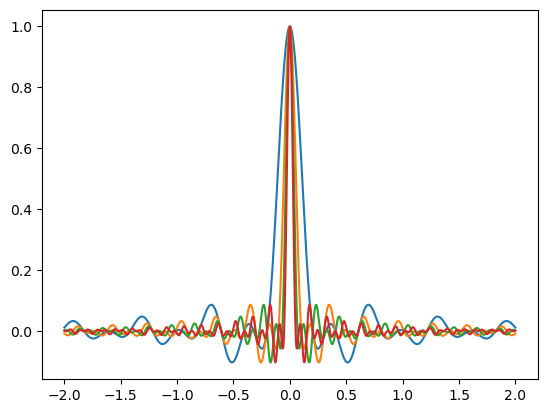

In [36]:
def phase_mismatch(delBeta,L):
    return np.sinc(delBeta*L/2)*np.exp(-1j*delBeta*L/2).real

delBeta_range = np.arange(-2*3.14,2*3.14+0.01,0.01)

plt.plot(delBeta_range/np.pi,phase_mismatch(delBeta_range,np.pi))
plt.plot(delBeta_range/np.pi,phase_mismatch(delBeta_range,2*np.pi))
plt.plot(delBeta_range/np.pi,phase_mismatch(delBeta_range,3*np.pi))
plt.plot(delBeta_range/np.pi,phase_mismatch(delBeta_range,4*np.pi))

In [116]:
max((np.abs(main_df[['Psi0', 'Psi1', 'Psi2', 'Psi4']])**2).max())

10.217188062693257

In [226]:
def Phi(lda,z):
    phi = -(1-np.exp(1j*lda*z))/(1j*lda)
    return phi

def wfcn_000_111(delbeta,z):
    lda_a = -delbeta + C1 - C2 - C3
    lda_b = -delbeta - C1 + C2 - C3
    lda_c = -delbeta - C1 - C2 + C3
    lda_d = -delbeta + C1 + C2 + C3
    
    return np.abs(Phi(lda_a,z) + Phi(lda_b,z) + Phi(lda_c,z) + Phi(lda_d,z))**2

def wfcn_100_011(delbeta,z):
    lda_a = -delbeta + C1 - C2 - C3
    lda_b = -delbeta - C1 + C2 - C3
    lda_c = -delbeta - C1 - C2 + C3
    lda_d = -delbeta + C1 + C2 + C3
    
    return np.abs(Phi(lda_a,z) - Phi(lda_b,z) - Phi(lda_c,z) + Phi(lda_d,z))**2

In [317]:
def plot_wfcn_anal(C1,C2,C3):
    #C1=1
    #C2=1.5
    #C3=2
    delbeta = np.linspace(-2*np.pi,2*np.pi,1000)
    lda_a = -delbeta + C1 - C2 - C3
    lda_b = -delbeta - C1 + C2 - C3
    lda_c = -delbeta - C1 - C2 + C3
    lda_d = -delbeta + C1 + C2 + C3

    z=2*np.pi

    plt.figure(figsize=(8,6),layout='constrained')
    plt.suptitle('C1=%d, C2=%d, C3=%d' %(C1,C2,C3))
    plt.subplot(211)
    plt.plot(delbeta,Phi(lda_a,z),label=r'$|\Phi_a|^2$')
    plt.plot(delbeta,Phi(lda_b,z),label=r'$|\Phi_b|^2$')
    plt.plot(delbeta,Phi(lda_c,z),label=r'$|\Phi_c|^2$')
    plt.plot(delbeta,Phi(lda_d,z),label=r'$|\Phi_d|^2$')
    plt.axvline(+ C1 - C2 - C3,linestyle='--',color='k',label=r'$\lambda_{a}^{\Delta \beta =0}$')
    plt.axvline(- C1 + C2 - C3,linestyle=':',color='k',label=r'$\lambda_{b}^{\Delta \beta =0}$')
    plt.axvline(- C1 - C2 + C3,linestyle='-',color='k',label=r'$\lambda_{c}^{\Delta \beta =0}$')
    plt.axvline(+ C1 + C2 + C3,linestyle='-.',color='k',label=r'$\lambda_{d}^{\Delta \beta =0}$')
    plt.ylabel(r'$|\Phi_j|^2$')
    plt.xlabel(r'$\Delta \beta$')
    plt.xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'])
    plt.legend(bbox_to_anchor=(1,1),ncol=2)
    
    plt.subplot(212)
    plt.plot(delbeta,np.abs(Phi(lda_a,z)+Phi(lda_b,z)+Phi(lda_c,z)+Phi(lda_d,z))**2,label=r'$|\Psi_{000,111}|^2$')
    plt.plot(delbeta,np.abs(Phi(lda_a,z)-Phi(lda_b,z)-Phi(lda_c,z)+Phi(lda_d,z))**2,label=r'$|\Psi_{100,011}|^2$')
    plt.plot(delbeta,np.abs(-Phi(lda_a,z)+Phi(lda_b,z)-Phi(lda_c,z)+Phi(lda_d,z))**2,label=r'$|\Psi_{010,101}|^2$')
    plt.plot(delbeta,np.abs(-Phi(lda_a,z)-Phi(lda_b,z)+Phi(lda_c,z)+Phi(lda_d,z))**2,label=r'$|\Psi_{001,110}|^2$')
    plt.axvline(+ C1 - C2 - C3,linestyle='--',color='k',label=r'$\lambda_{a}^{\Delta \beta =0}$')
    plt.axvline(- C1 + C2 - C3,linestyle=':',color='k',label=r'$\lambda_{b}^{\Delta \beta =0}$')
    plt.axvline(- C1 - C2 + C3,linestyle='-',color='k',label=r'$\lambda_{c}^{\Delta \beta =0}$')
    plt.axvline(+ C1 + C2 + C3,linestyle='-.',color='k',label=r'$\lambda_{d}^{\Delta \beta =0}$')
    plt.xlabel(r'$\Delta \beta$')
    plt.ylabel(r'$|\Psi|^2$')
    plt.xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'])
    plt.legend(bbox_to_anchor=(1,1),ncol=2)

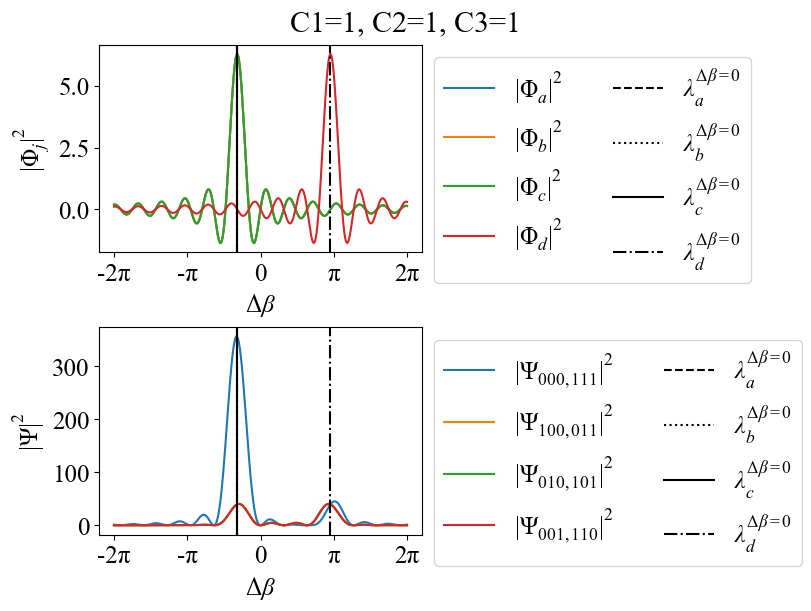

In [318]:
plot_wfcn_anal(1,1,1)

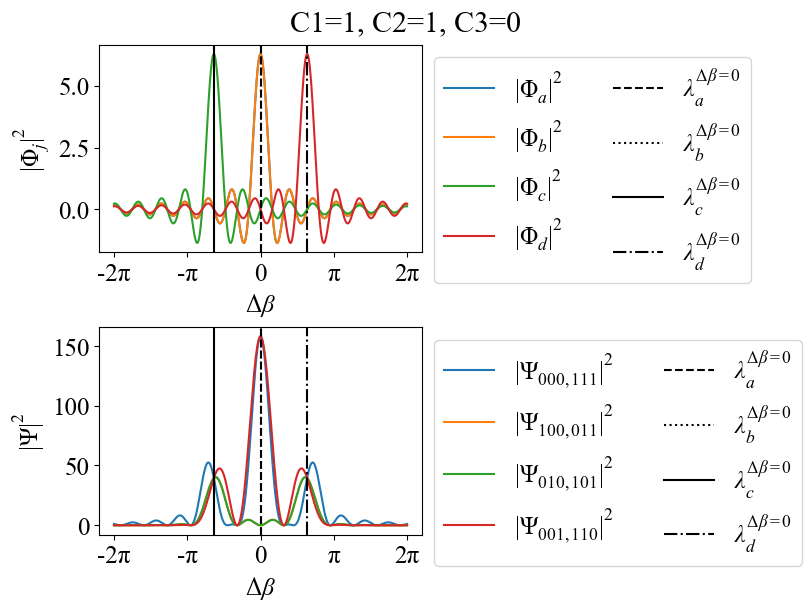

In [319]:
plot_wfcn_anal(1,1,0)

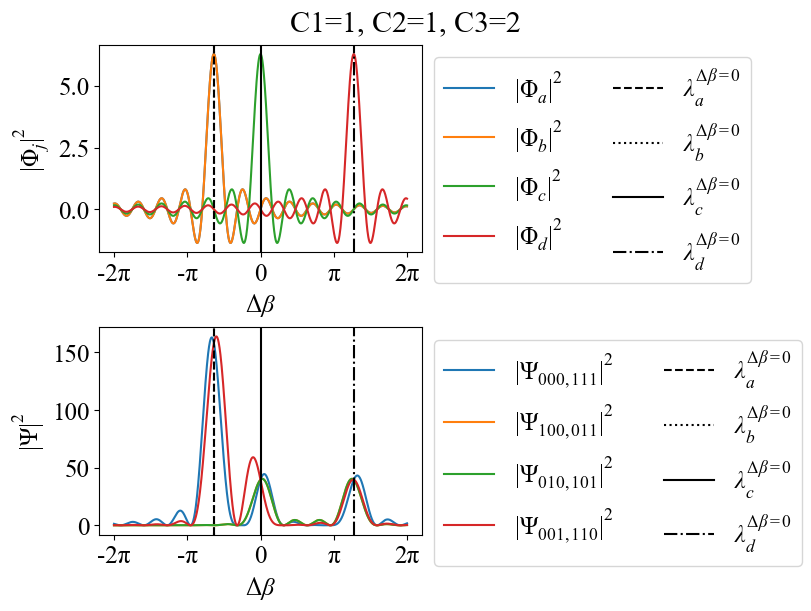

In [320]:
plot_wfcn_anal(1,1,2)

In [262]:
def GHZ_like(z,delBeta):
    C1 = 0.1
    return C1**2 * z**2 / (4+delBeta**2 * z**2)

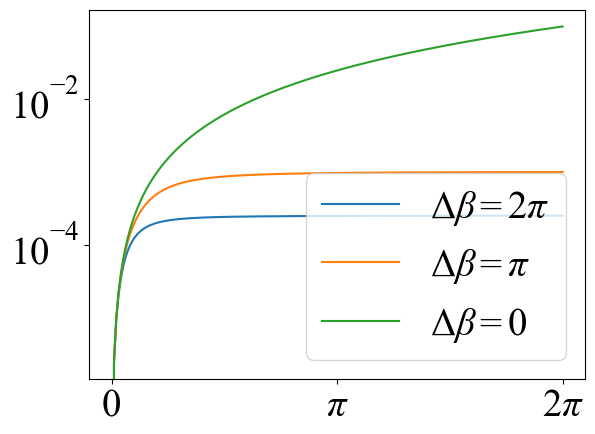

In [263]:
z_range = np.linspace(0,2*np.pi,200)
plt.plot(z_range, GHZ_like(z_range, 2*np.pi),label=r'$\Delta \beta=2\pi$')
plt.plot(z_range, GHZ_like(z_range, np.pi),label=r'$\Delta \beta=\pi$')
plt.plot(z_range, GHZ_like(z_range, 0),label=r'$\Delta \beta=0$')
plt.xticks([0,np.pi,2*np.pi],['0',r'$\pi$',r'$2\pi$'])
plt.yscale('log')
plt.legend()

## MYB Workspace - Numerical Solution

### Solve differential equation for fixed C1=C2 and C3 over z and $\Delta \beta$

In [48]:
n_photon = 3
n_wg = 2

C3 = 1
init_C1 = 1
init_C2 = 1
max_z = 2*np.pi
zs=np.linspace(0,max_z,200)

init_gamma = 1
init_del_beta = 0
init_del_phi = 0


Ez0 = [1 + 0j, 1 + 0j]                  # Complex amplitude of pump at waveguide 1 and 2
Psi0 = [0] * (n_wg**n_photon)           # Initial wavefunction set to zero
Ez_Psi0 = Ez0 + Psi0

delBeta_range = np.arange(-2*3.14,2*3.14+0.01,0.01)

df_list= []
for delBeta in delBeta_range:
    Ez_Psi = solve_ivp(coupled_SPDC_dEz_dz_dPsi_dz
                        , [0, max_z]
                        , Ez_Psi0
                        # , max_step=max_step_z  # comment out if the "t_eval=" is specified
                        , t_eval=zs
                        , dense_output=True
                        , args=(init_C1, init_C2, C3, init_gamma, delBeta, init_del_phi)) 

    data = pd.DataFrame(Ez_Psi.y.transpose(),columns=['Ez1','Ez2','Psi0','Psi1','Psi2','Psi3','Psi4','Psi5','Psi6','Psi7'])
    data['z']=Ez_Psi.t
    data.insert(0, 'z', data.pop('z')) 
    
    Psi = data[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']]
    Psi = np.array(Psi)
    norm_fac = np.sqrt(np.sum(np.abs(Psi)**2))

    # Include metadata
    data['NormFac'] = norm_fac
    data['C1'] = init_C1
    data['C2'] = init_C2
    data['C3'] = C3
    data['Gamma'] = init_gamma
    data['delBeta'] = round(delBeta, 3)
    data['delPhi'] = init_del_phi
    df_list.append(data)

main_df = pd.concat(df_list,ignore_index=True)

In [49]:
main_df.to_csv('240702 - SPDC-Waveguide-Data/240718_solution_C1=C2=0.1_C3=0.1_delBsweep_zsweep.csv')

### Plot results for z-propagation over $\Delta \beta$

In [7]:
z_prop_C3_0 = main_df

In [6]:
z_prop_C3_1 = read_csv2('240702 - SPDC-Waveguide-Data/240715_solution_C1=C2=1_C3=1_delBsweep_zsweep.csv')
z_prop_C3_2 = read_csv2('240702 - SPDC-Waveguide-Data/240715_solution_C1=C2=1_C3=2_delBsweep_zsweep.csv')
z_prop_C3_3 = read_csv2('240702 - SPDC-Waveguide-Data/240718_solution_C1=C2=0.1_C3=0.1_delBsweep_zsweep.csv')

In [9]:
# Plot individual wavefunctions
def plot_each_wfcn(main_df):
    delBetas = list(set(main_df['delBeta']))
    delBetas.sort()

    for k in Psi_index_plot:
        array_2d = []
        for delBeta in delBetas:
            subdf = main_df[main_df['delBeta'] == delBeta]
            array_2d.append(np.square(np.abs(subdf['Psi%s' %(str(k))])))
        #    plt.plot(np.square(np.abs(subdf['Psi5'])))

        plt.figure(figsize=(3,3))
        plt.title(r'$|\Psi_{%s}|^2$' %(Psi_index[k]))
        plt.imshow(np.transpose(array_2d),extent=(min(delBetas), max(delBetas),0,max_z) ,origin='lower',aspect='auto')
        plt.xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'])
        plt.yticks([0,np.pi,2*np.pi],[0,'π','2π'])
        plt.colorbar(fraction=0.046, pad=0.04,label='Intensity')    
        plt.xlabel(r'$\Delta \beta$')
        plt.ylabel('z')
        plt.show()

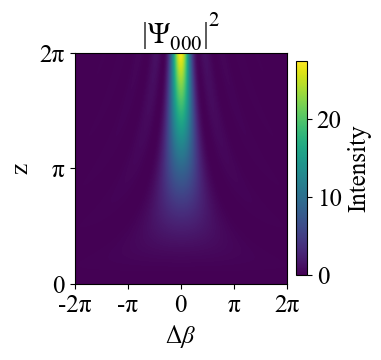

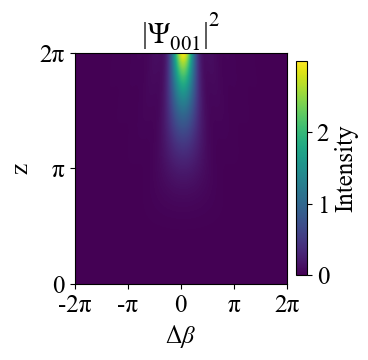

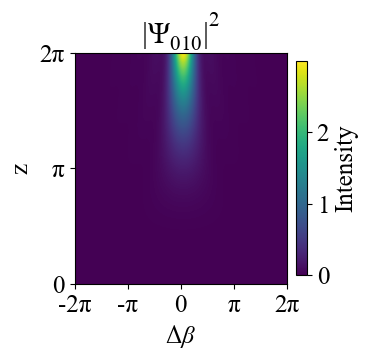

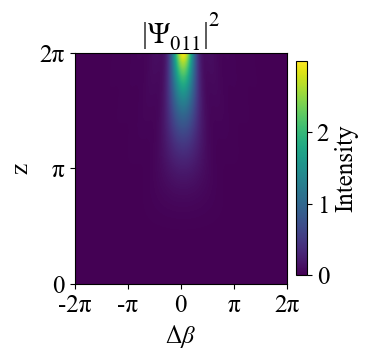

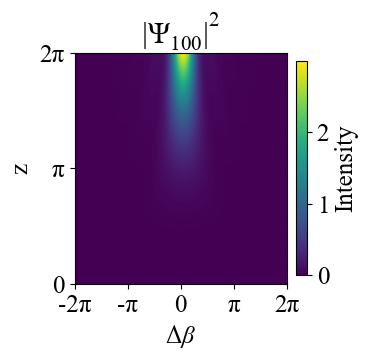

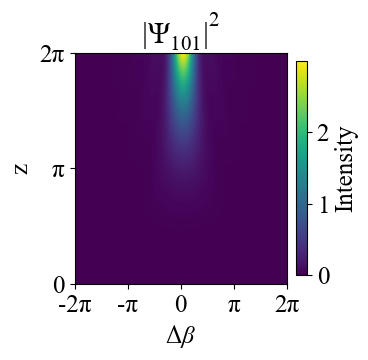

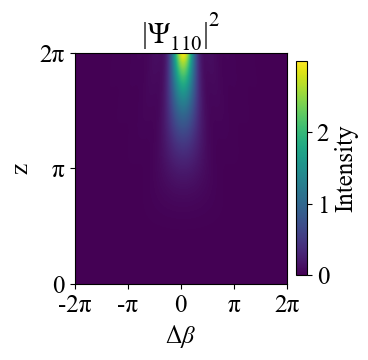

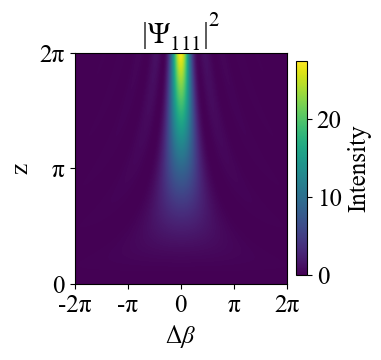

In [10]:
plot_each_wfcn(z_prop_C3_3)

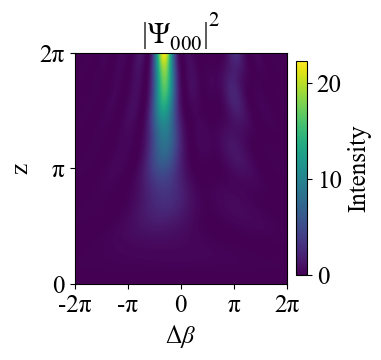

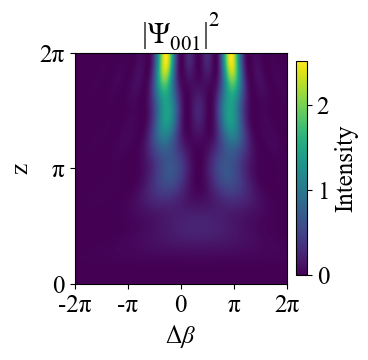

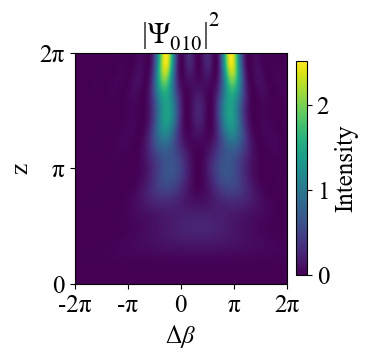

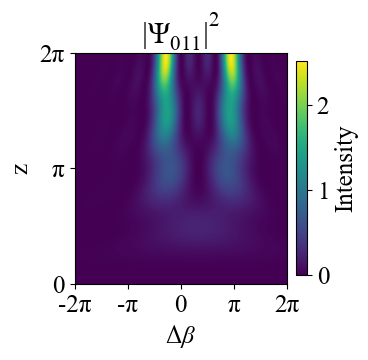

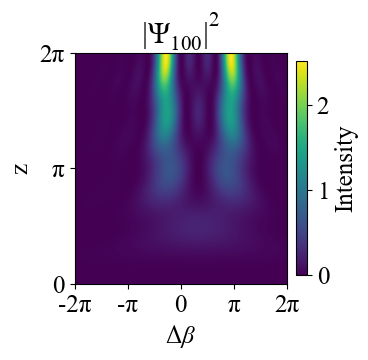

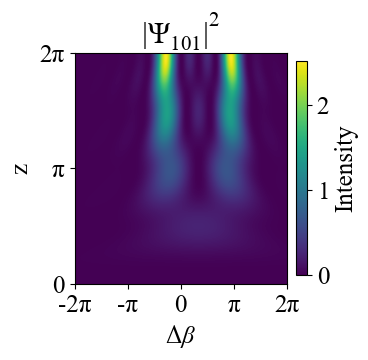

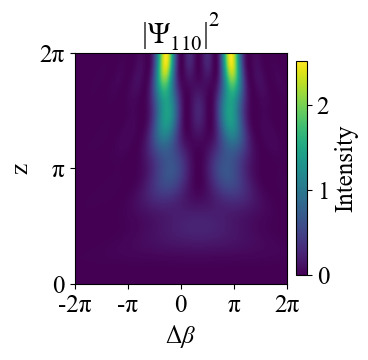

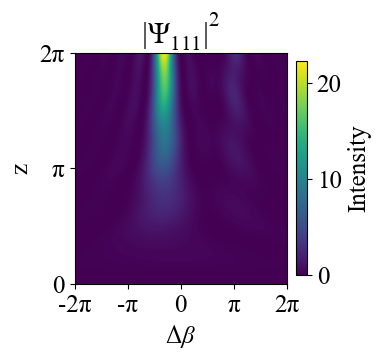

In [64]:
plot_each_wfcn(z_prop_C3_1)

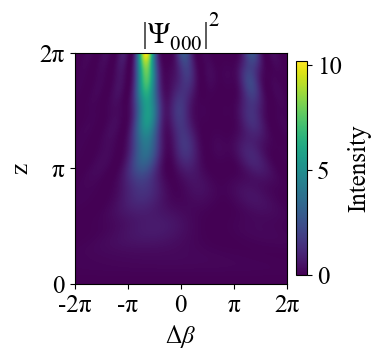

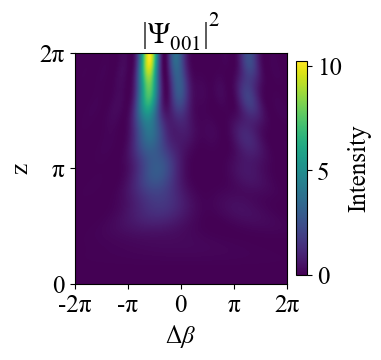

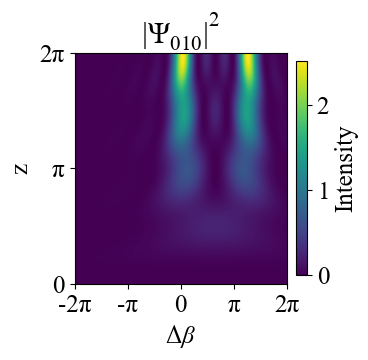

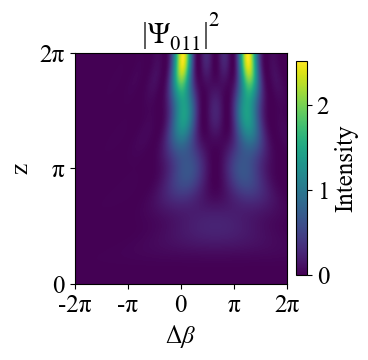

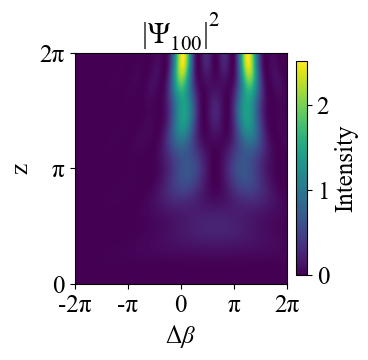

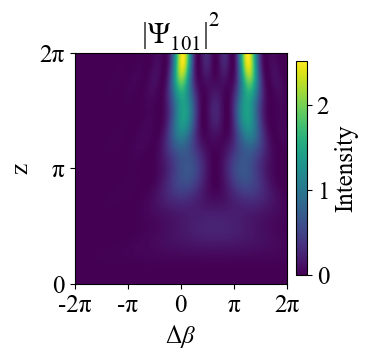

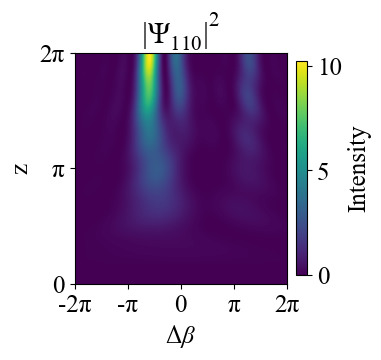

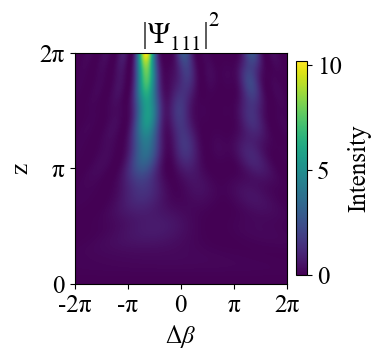

In [65]:
plot_each_wfcn(z_prop_C3_2)

In [8]:
# Plot all wavefunctions together - Amplitude
def plot_all_wfcn(main_df,lines=[]):
    delBetas = list(set(main_df['delBeta']))
    delBetas.sort()

    #plt.figure(figsize=(10,6))
    # sns.set(font_scale=1.0,style='white', palette='deep',font='Arial',rc = {'figure.figsize':(8,5)})
    fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(16,8))
    loop_n=0
    for k,ax in zip(Psi_index_plot,axes.flat):
        array_2d = []
        loop_n=loop_n+1
        for delBeta in delBetas:
            subdf = main_df[main_df['delBeta'] == delBeta]
            array_2d.append(np.square(np.abs(subdf['Psi%s' %(str(k))])))
        #    plt.plot(np.square(np.abs(subdf['Psi5'])))
        # plt.subplot(2,4,loop_n)
        ax.set_title(r'$|\Psi_{%s}|^2$' %(str(Psi_index[k])))
        im = ax.imshow(np.transpose(array_2d),extent=(min(delBetas), max(delBetas),0,max_z) ,origin='lower',aspect=2,cmap='YlGnBu')#,aspect='auto')
        #ax.axvline(4.28,linestyle='--',color='white')
        if len(lines)> 0:
            for line in lines:
                ax.axvline(line,linestyle=':',color='white')
        ax.set_xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'])
        ax.set_yticks([0,np.pi,2*np.pi],[0,'π','2π'])
        ax.set_xlabel(r'$\Delta \beta$')
        #ax.set_ylabel('z')
        #im.colorbar(fraction=0.046, pad=0.04,label='Intensity')     
        plt.colorbar(im,ax=ax,shrink=0.8)
    plt.show()

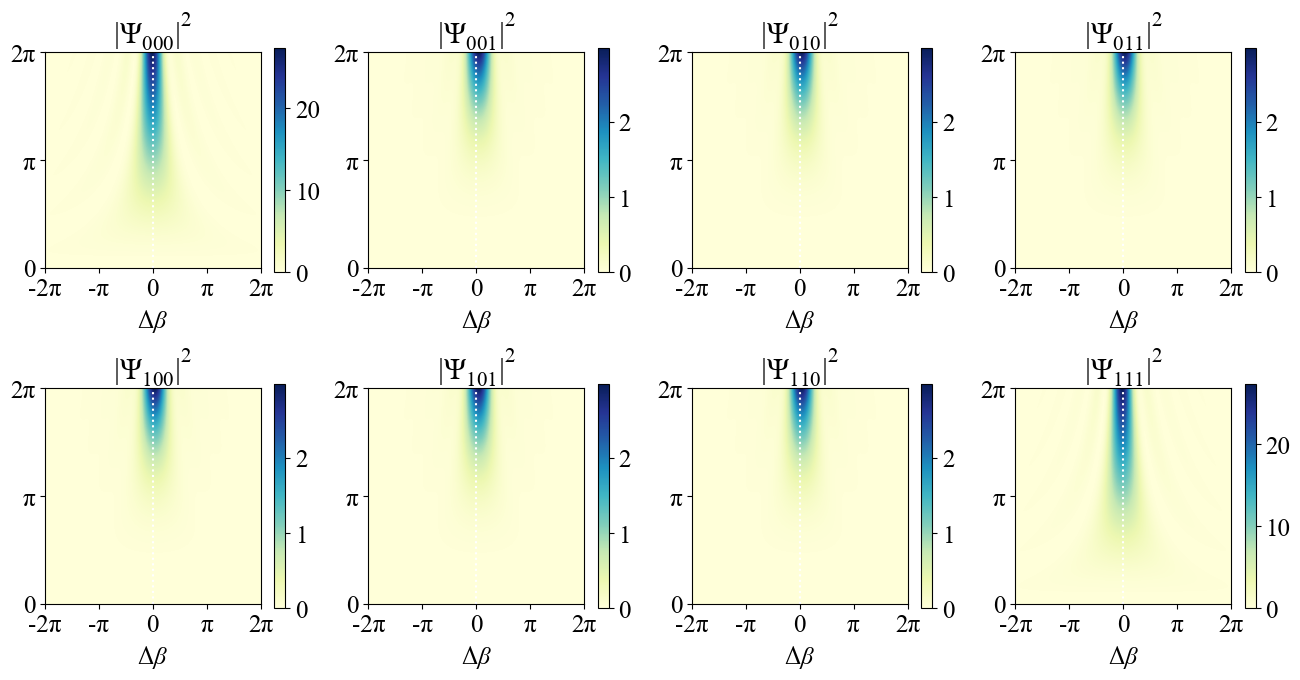

In [11]:
plot_all_wfcn(z_prop_C3_3,[0])

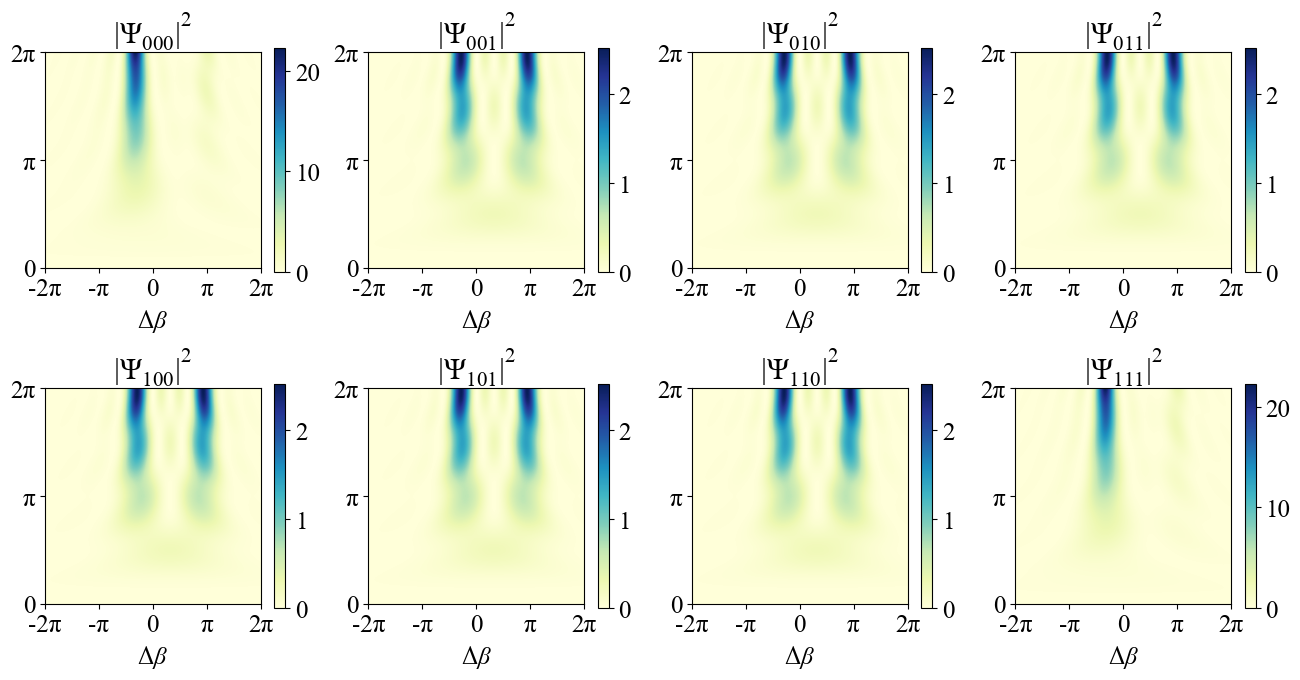

In [12]:
plot_all_wfcn(z_prop_C3_1,[])

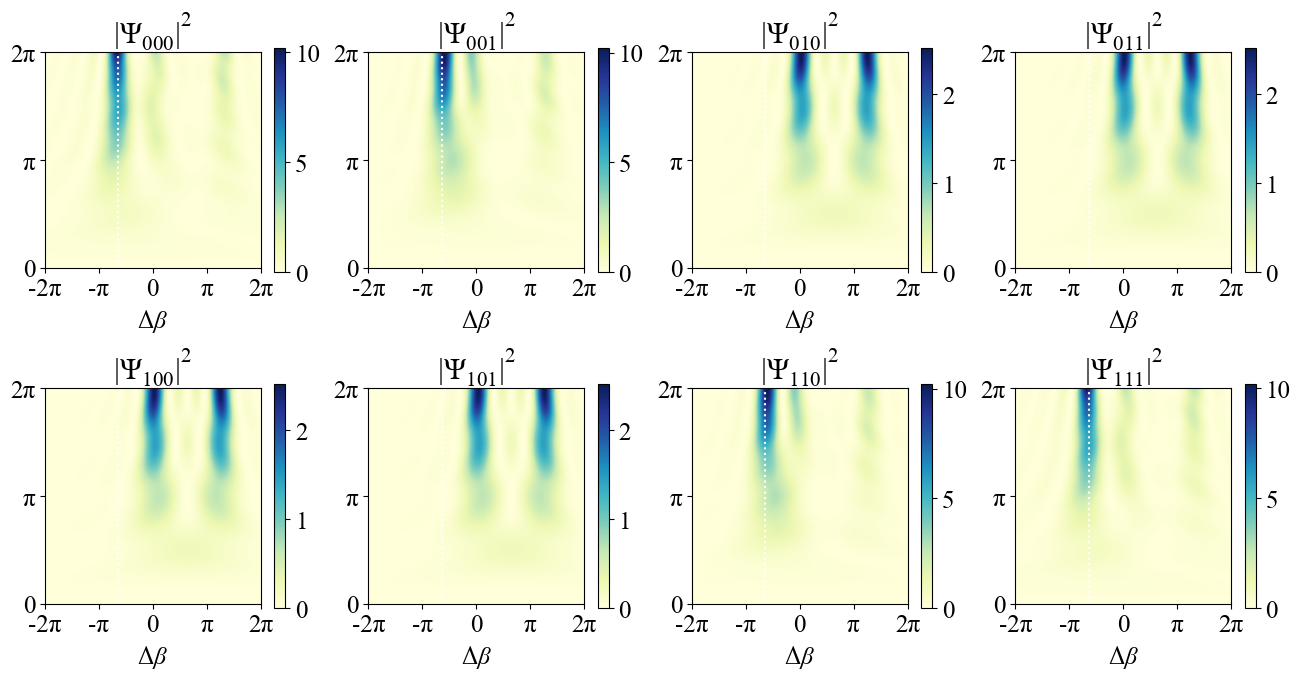

In [13]:
plot_all_wfcn(z_prop_C3_2,[-2])

In [82]:
# Plot all wavefunctions togeteher - Phases
def plot_all_wfcn_phase(main_df,lines=[]):
    delBetas = list(set(main_df['delBeta']))
    delBetas.sort()

    #plt.figure(figsize=(10,6))
    # sns.set(font_scale=1.0,style='white', palette='deep',font='Arial')#,rc = {'figure.figsize':(8,5)})
    fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(16,8))
    loop_n=0
    for k,ax in zip(Psi_index_plot,axes.flat):
        array_2d = []
        loop_n=loop_n+1
        for delBeta in delBetas:
            subdf = main_df[main_df['delBeta'] == delBeta]
            array_2d.append(np.angle(subdf['Psi%s' %(str(k))]))
        #    plt.plot(np.square(np.abs(subdf['Psi5'])))
        # plt.subplot(2,4,loop_n)
        ax.set_title(r'$|\Psi_{%s}|^2$' %(Psi_index[k]))
        im = ax.imshow(np.transpose(array_2d),extent=(min(delBetas), max(delBetas),0,max_z) ,origin='lower',aspect=2,cmap='twilight')#,aspect='auto')
        if len(lines)> 0:
            for line in lines:
                ax.axvline(line,linestyle=':',color='white')
        ax.set_xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'])
        ax.set_yticks([0,np.pi,2*np.pi],[0,'π','2π'])
        ax.set_xlabel(r'$\Delta \beta$')
        #ax.set_ylabel('z')
        #im.colorbar(fraction=0.046, pad=0.04,label='Intensity')     
        plt.colorbar(im,ax=ax,shrink=0.8)
    #fig.colorbar(im, ax=axes.ravel().tolist(),shrink=0.85)
    #fig.xlabel(r'$\Delta \phi$')
    plt.show()

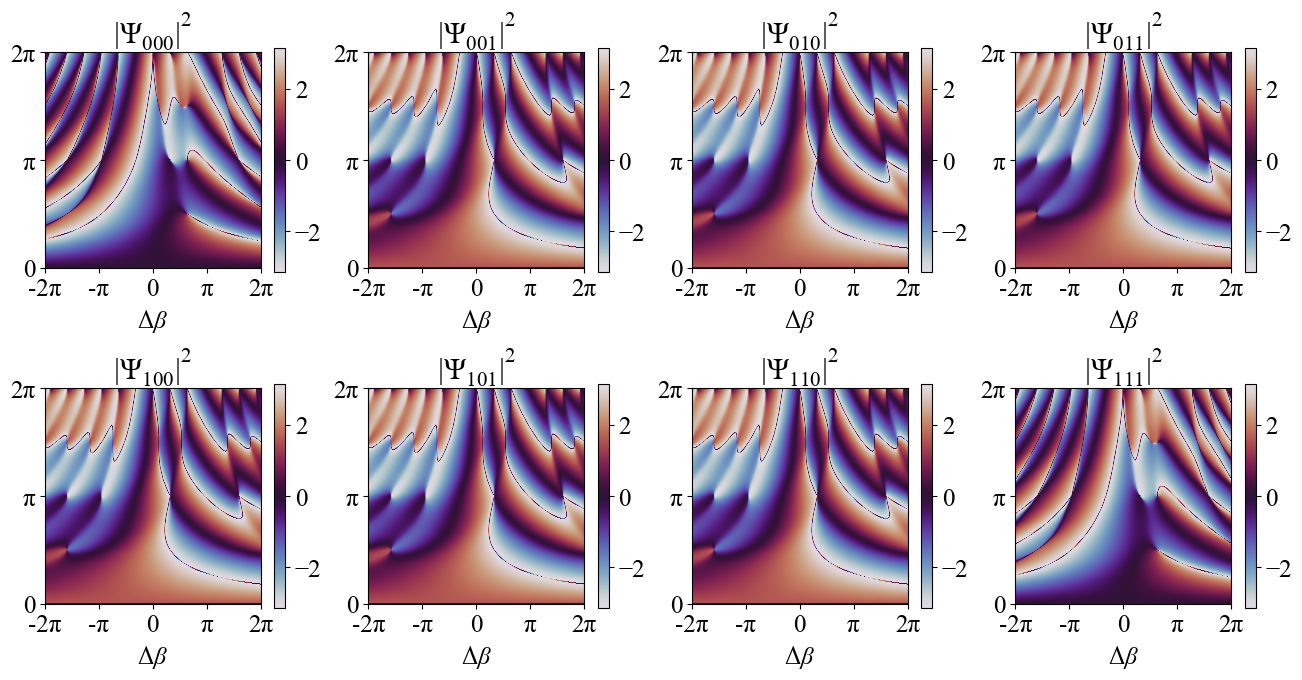

In [83]:
plot_all_wfcn_phase(z_prop_C3_1,[])

In [18]:
# Plot all wavefunctions togeteher for publication

def plot_wfcns(main_df,lines=[]):
    delBetas = list(set(main_df['delBeta']))
    delBetas.sort()

    Psi_index_condensed = [0,2,1,4]
    titles=[r'$|\Psi_{000}|^2=|\Psi_{111}|^2$',
           r'$|\Psi_{100}|^2=|\Psi_{011}|^2$',
           r'$|\Psi_{010}|^2=|\Psi_{101}|^2$',
           r'$|\Psi_{001}|^2=|\Psi_{110}|^2$',]

    # sns.set(font_scale=1.0,style='white', palette='deep',font='Arial',rc = {'figure.figsize':(11,3)})
    fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(4,10),sharex=False,layout='constrained')
    max_value = max((np.abs(main_df[['Psi0', 'Psi1', 'Psi2', 'Psi4']])**2).max())
    normalizer = Normalize(0, 1)
    imx = cm.ScalarMappable(norm=normalizer)

    for loop,k,ax in zip(range(len(Psi_index_condensed)),Psi_index_condensed,axes.flat):
        array_2d = []
        for delBeta in delBetas:
            subdf = main_df[main_df['delBeta'] == delBeta]
            array_2d.append(np.square(np.abs(subdf['Psi%s' %(str(k))]))/max_value)

        #ax.set_title(titles[loop])

        im = ax.imshow(np.transpose(array_2d),extent=(min(delBetas), max(delBetas),0,max_z) ,origin='lower',aspect=2, norm=normalizer,cmap='viridis')
        if len(lines) > 0:
            for line in lines:
                if loop in [0,3]:
                    ax.axvline(line,linestyle=':',color='white',alpha=0.7,linewidth=3)
        #ax.set_xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'],fontsize=18)
        #ax.set_xticks([-5,-3,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'],fontsize=18)
        ax.set_yticks([0,np.pi,2*np.pi],[0,'π','2π'])
        #ax.set_xlabel(r'$\Delta \beta$')
        #ax.set_ylabel(titles[loop])
        cbar = plt.colorbar(im,ax=ax,shrink=1,label=titles[loop])
        cbar.set_ticks([0,0.5,1])
        #cbar.set_ticklabels([mn,md,mx])
        #im.colorbar(fraction=0.046, pad=0.04,label='Intensity')     
    #fig.subplots_adjust(hspace=None)
    #cbar = fig.colorbar(imx, ax=axes.ravel().tolist(), shrink=0.7)
    #cbar.set_ticks([0,5,10])
    #fig.supxlabel(r'Phase Difference $\Delta \beta$')
    fig.supylabel(r'Propagation Distance, $z$')
    plt.savefig('240702 - SPDC-Waveguide-Data/240807_z_prop_C1=C2=1_C3=1_delBsweep_zsweep.jpg',dpi=300)
    plt.show()

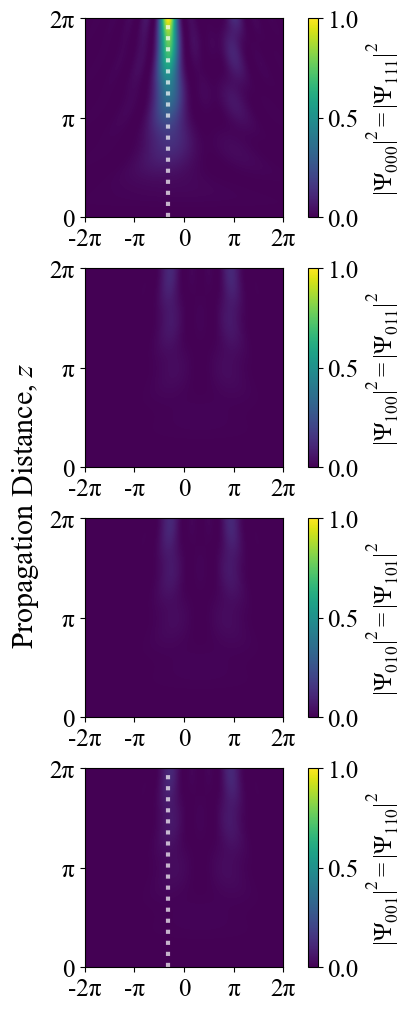

In [19]:
plot_wfcns(z_prop_C3_1,lines=[-1])

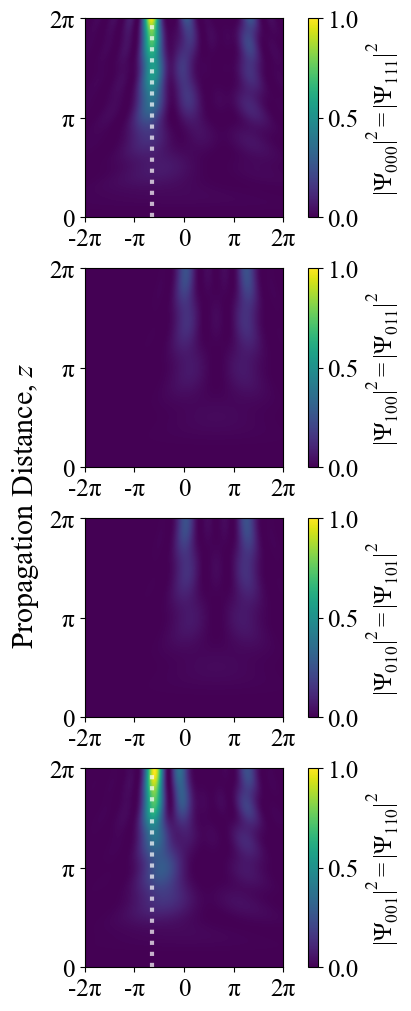

In [17]:
plot_wfcns(z_prop_C3_2,lines=[-2])

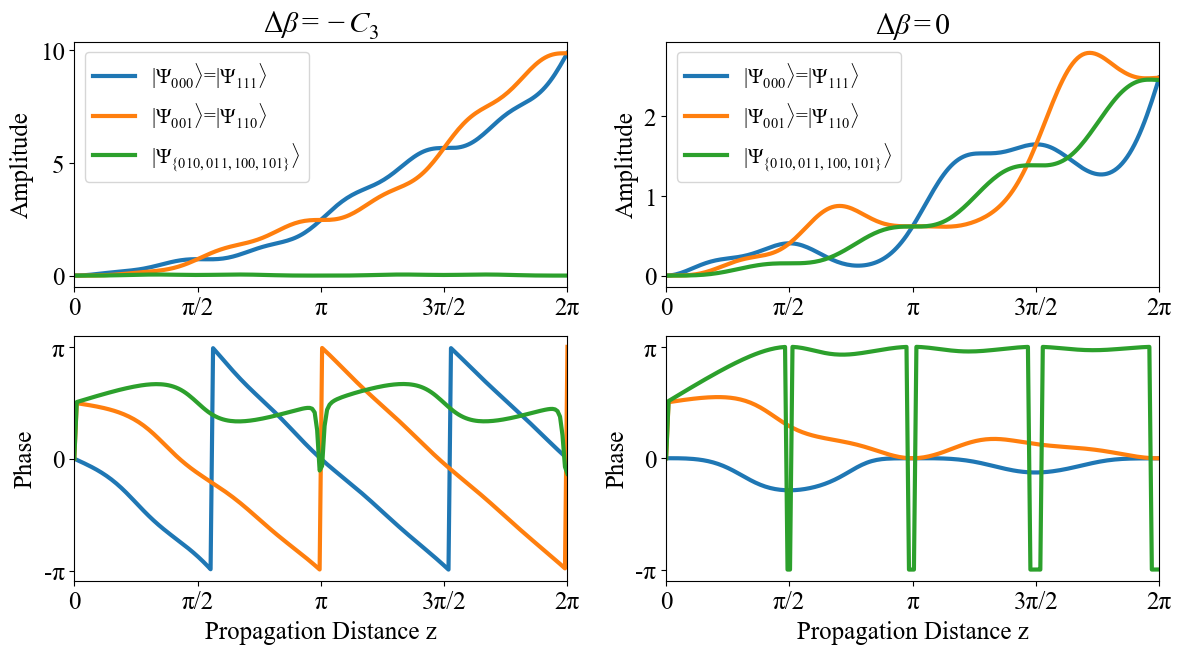

In [468]:
# Plot the wavefuction at fixed z=2pi and \delta \beta = -C3.

sub_df=main_df[main_df['delBeta'] == -2]
# import seaborn as sns
#sns.set(font_scale=1.5,style='white', palette='deep',font='Arial',rc = {'figure.figsize':(8,6)})

# Condensed plot
plt.figure(figsize=(14,7))

plt.subplot(221)
#plt.title(r'$C_2=C_2=2, C_3=4$' +'\n' +r'$A_1=A_2=1+0j, \Delta \beta=-C_3, \Delta \varphi=0$')
plt.title(r'$\Delta \beta=-C_3$')
plt.plot(sub_df['z'],np.abs(sub_df['Psi0'])**2,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.abs(sub_df['Psi4'])**2,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.abs(sub_df['Psi1'])**2,label=r'|$\Psi_{\{010,011,100,101\}}\rangle$',linewidth=3)
#plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')

plt.xlim(0,2*np.pi)
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
plt.legend(fontsize=15,loc='best')
plt.ylabel('Amplitude')

plt.subplot(223)

plt.plot(sub_df['z'],np.angle(sub_df['Psi0']) ,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi3']) ,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi5']) ,label=r'|$\Psi_{\{010,011,100,101\}}\rangle$',linewidth=3)
#plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')

plt.xlabel('Propagation Distance z')
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
plt.xlim(0,2*np.pi)
plt.yticks([-np.pi,0,np.pi],['-π','0','π'])
plt.ylabel('Phase')
#plt.legend(fontsize=14,loc=2)


sub_df=main_df[main_df['delBeta'] == 0]

plt.subplot(222)
#plt.title(r'$C_2=C_2=2, C_3=4$' +'\n' +r'$A_1=A_2=1+0j, \Delta \beta=-C_3, \Delta \varphi=0$')
plt.title(r'$\Delta \beta=0$')
plt.plot(sub_df['z'],np.abs(sub_df['Psi0'])**2,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.abs(sub_df['Psi4'])**2,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.abs(sub_df['Psi1'])**2,label=r'|$\Psi_{\{010,011,100,101\}}\rangle$',linewidth=3)
#plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')

plt.xlim(0,2*np.pi)
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
plt.legend(fontsize=15,loc='best')
plt.ylabel('Amplitude')

plt.subplot(224)

plt.plot(sub_df['z'],np.angle(sub_df['Psi0']) ,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi3']) ,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi5']) ,label=r'|$\Psi_{\{010,011,100,101\}}\rangle$',linewidth=3)
#plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
#plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')

plt.xlabel('Propagation Distance z')
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
plt.xlim(0,2*np.pi)
plt.yticks([-np.pi,0,np.pi],['-π','0','π'])
plt.ylabel('Phase')


plt.show()

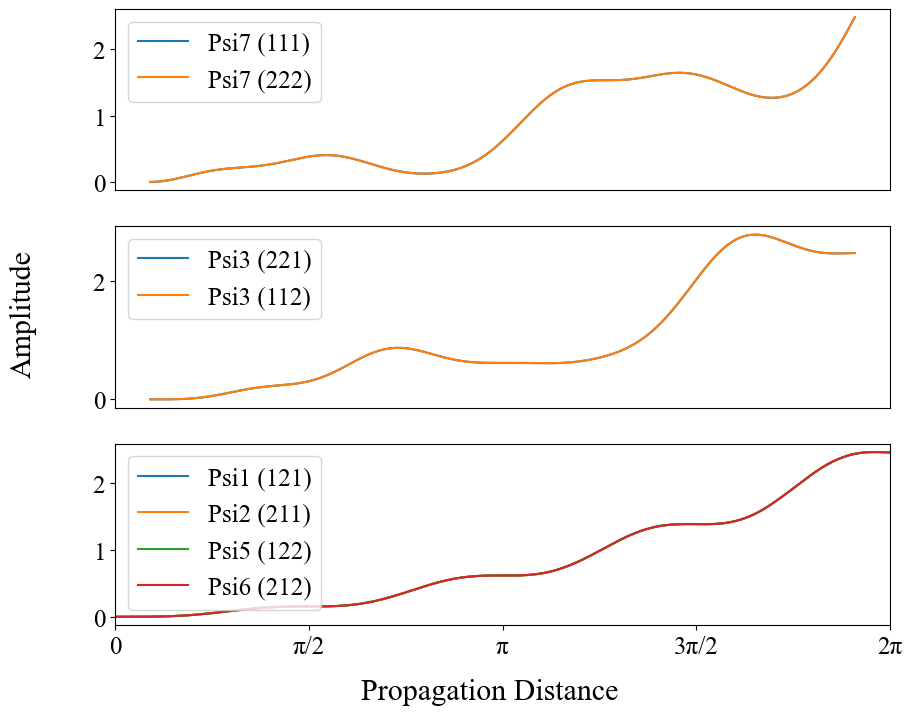

In [471]:
# Individual plots showing the equivalence of the wavefunctions 

fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(311)
ax1.plot(sub_df['z'],np.abs(sub_df['Psi0'])**2,label='Psi7 (111)')
ax1.plot(sub_df['z'],np.abs(sub_df['Psi7'])**2,label='Psi7 (222)')
ax1.legend()
ax1.set_xticks([])

ax2 = fig.add_subplot(312)
ax2.plot(sub_df['z'],np.abs(sub_df['Psi3'])**2,label='Psi3 (221)')
ax2.plot(sub_df['z'],np.abs(sub_df['Psi4'])**2,label='Psi3 (112)')
ax2.set_xticks([])
ax2.legend()

ax3 = fig.add_subplot(313)
ax3.plot(sub_df['z'],np.abs(sub_df['Psi1'])**2,label='Psi1 (121)')
ax3.plot(sub_df['z'],np.abs(sub_df['Psi2'])**2,label='Psi2 (211)')
ax3.plot(sub_df['z'],np.abs(sub_df['Psi5'])**2,label='Psi5 (122)')
ax3.plot(sub_df['z'],np.abs(sub_df['Psi6'])**2,label='Psi6 (212)')
ax3.legend(loc=2)
ax3.set_xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
ax3.set_xlim(0,2*np.pi)

fig.supxlabel('Propagation Distance')
fig.supylabel('Amplitude')
plt.show()

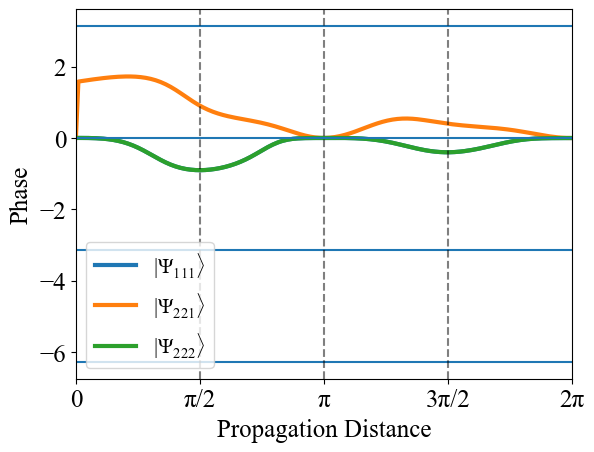

In [472]:
# Condensed plot for Phases

# sns.set(font_scale=1.0,style='white', palette='deep',font='Arial',rc = {'figure.figsize':(8,5)})
plt.figure()
#plt.plot(sub_df['z'],np.angle(sub_df['Psi0']) + np.angle(sub_df['Psi7']) + np.angle(sub_df['Psi3'])+ np.angle(sub_df['Psi4']) ,label=r'|$\Psi_{111}\rangle$+|$\Psi_{222}\rangle$+$\Psi_{112}\rangle$+$\Psi_{221}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi0']) ,label=r'|$\Psi_{111}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi3']) ,label=r'|$\Psi_{221}\rangle$',linewidth=3)
plt.plot(sub_df['z'],np.angle(sub_df['Psi7']) ,label=r'|$\Psi_{222}\rangle$',linewidth=3)
plt.axhline(-2*np.pi)
plt.axhline(-np.pi)
plt.axhline(np.pi)
plt.axhline(0)
plt.axvline(np.pi*1/2,linestyle='--',alpha=0.5,color='k')
plt.axvline(np.pi*1,linestyle='--',alpha=0.5,color='k')
plt.axvline(np.pi*3/2,linestyle='--',alpha=0.5,color='k')


#plt.title(r'$\Delta \beta=-0.5, \Delta \varphi=0,$' +'\n' +r'$A_1=A_2=1+0j, C_1=C_2=0.25, C_3=0.5$')
plt.xlabel('Propagation Distance')
plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],[0,'π/2','π','3π/2','2π'])
plt.xlim(0,2*np.pi)
plt.ylabel('Phase')

#plt.text(np.pi*1/2-0.5,0.75,'π/2')
#plt.text(np.pi*1.08+0.1,0.75,'1.08π')
#plt.text(np.pi*3/2+0.1,0.75,'3π/2')

plt.legend(fontsize=15)
plt.show()

## Heralded Bell State and Factorisable State

### Solve differential equation at fixed z=2pi, $\Delta \beta$=-C3 (0), iterate over C1=C2 and C3 for HBS (FS)

In [501]:
n_photon = 3
n_wg = 2

C3 = 
init_C1 = 0.1
init_C2 = 0.1
max_z = 2*np.pi
zs=np.linspace(0,max_z,50)
zs=[max_z]

init_gamma = 1
init_del_beta = -2*np.pi
init_del_phi = 0


Ez0 = [1 + 0j, 1 + 0j] 
Psi0 = [0] * (n_wg**n_photon)
Ez_Psi0 = Ez0 + Psi0

#delBeta_range = np.linspace(-1.8,1.8,50)
delPhi_range = np.arange(-2*3.14,2*3.14+0.01,0.01)
C3_list=np.arange(0,3+0.01,0.01)
C1_list=np.arange(0.1,3+0.01,0.01)

df_list= [] 
for C1 in C1_list:
    for C3 in C3_list:
        
        C1 = round(C1,2)
        C3 = round(C3,2)
        delBeta = -C3
        Ez_Psi = solve_ivp(coupled_SPDC_dEz_dz_dPsi_dz
                            , [0, max_z]
                            , Ez_Psi0
                            # , max_step=max_step_z  # comment out if the "t_eval=" is specified
                            , t_eval=zs
                            , dense_output=True
                            , args=(C1, C1, C3, init_gamma, delBeta, 0)) 

        data = pd.DataFrame(Ez_Psi.y.transpose(),columns=['Ez1','Ez2','Psi0','Psi1','Psi2','Psi3','Psi4','Psi5','Psi6','Psi7'])
        data['z'] = Ez_Psi.t
        data.insert(0, 'z', data.pop('z')) 

        Psi = data[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']]
        Psi = np.array(Psi)
        norm_fac = np.sqrt(np.sum(np.abs(Psi)**2))

        # Include metadata
        data['NormFac'] = norm_fac
        data['C1'] = C1
        data['C2'] = C1
        data['C3'] = C3
        data['Gamma'] = init_gamma
        data['delBeta'] = delBeta
        data['delPhi'] = round(delBeta, 3)
        df_list.append(data)
    
main_df2 = pd.concat(df_list,ignore_index=True)
main_df2.to_csv('240702 - SPDC-Waveguide-Data/240702_solution_C1=C2sweep_C3sweep_delB=-C3_z=2pi.csv')

### Post-process HBS Data

In [5]:
# Read data for HBS
C3sweep_HBS = read_csv2('240702 - SPDC-Waveguide-Data/240702_solution_C1=C2sweep_C3sweep_delB=-C3_z=2pi.csv')

In [6]:
# Read data for FS
C3sweep_FS = read_csv2('240702 - SPDC-Waveguide-Data/240702_solution_C1=C2sweep_C3sweep_delB=0_z=2pi.csv')

In [7]:

def plot_C3_dependence(main_df):
    C3_list = list(set(main_df['C3']))
    C3_list.sort()
    delBetas = list(set(main_df['delBeta']))
    delBetas.sort()

    fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(16,7),layout='constrained')
    loop_n=0
    max_C3 = 3
    for k,ax in zip(Psi_index_plot,axes.flat):
        array_2d = []
        loop_n=loop_n+1
        for C3 in C3_list:
            #subdf = main_df[main_df['C3'] == C3]
            subdf = main_df[np.abs(main_df['C3']-C3) < 0.001]
            # subdf = subdf[subdf['z'] == zs[-1]]
            # array_2d.append(np.square(np.abs(subdf['Psi%s' %(str(k))])))
            array_2d.append(np.array(np.square(np.abs(subdf['Psi%s' %(str(k))]))))
        #    plt.plot(np.square(np.abs(subdf['Psi5'])))
        # plt.subplot(2,4,loop_n)
        ax.set_title(r'$|\psi_{%s}|^2$' %(str(Psi_index[k])))
        im = ax.imshow(np.transpose(array_2d),extent=(0, 3,0.1,3) ,origin='lower',aspect='auto')#,aspect='auto')
        #ax.axvline(4.28,linestyle='--',color='white')
        #if loop_n in [1,2,7,8]:
            #ax.plot([0,-max_C3],[0,max_C3],linestyle='--',color='white')
        #else:
            #ax.plot([0,-max_C3],[0,max_C3],linestyle='--',color='white')
            #ax.plot([-max_C3,0],[0,max_C3],linestyle='-.',color='k')
            #ax.plot([max_C3,2*max_C3],[0,max_C3],linestyle='-.',color='k')
        #ax.set_xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi], ['-2π','-π','0','π','2π'])
        #ax.set_yticks([0,1,2],[0,'1','2'])
        ax.set_ylabel('C1=C2')
        ax.set_xlabel('C3')
        #im.colorbar(fraction=0.046, pad=0.04,label='Intensity')     
        plt.colorbar(im,ax=ax,shrink=0.85)
    #fig.colorbar(im, ax=axes.ravel().tolist(),shrink=0.85)
    #fig.xlabel(r'$\Delta \phi$')
    plt.show()

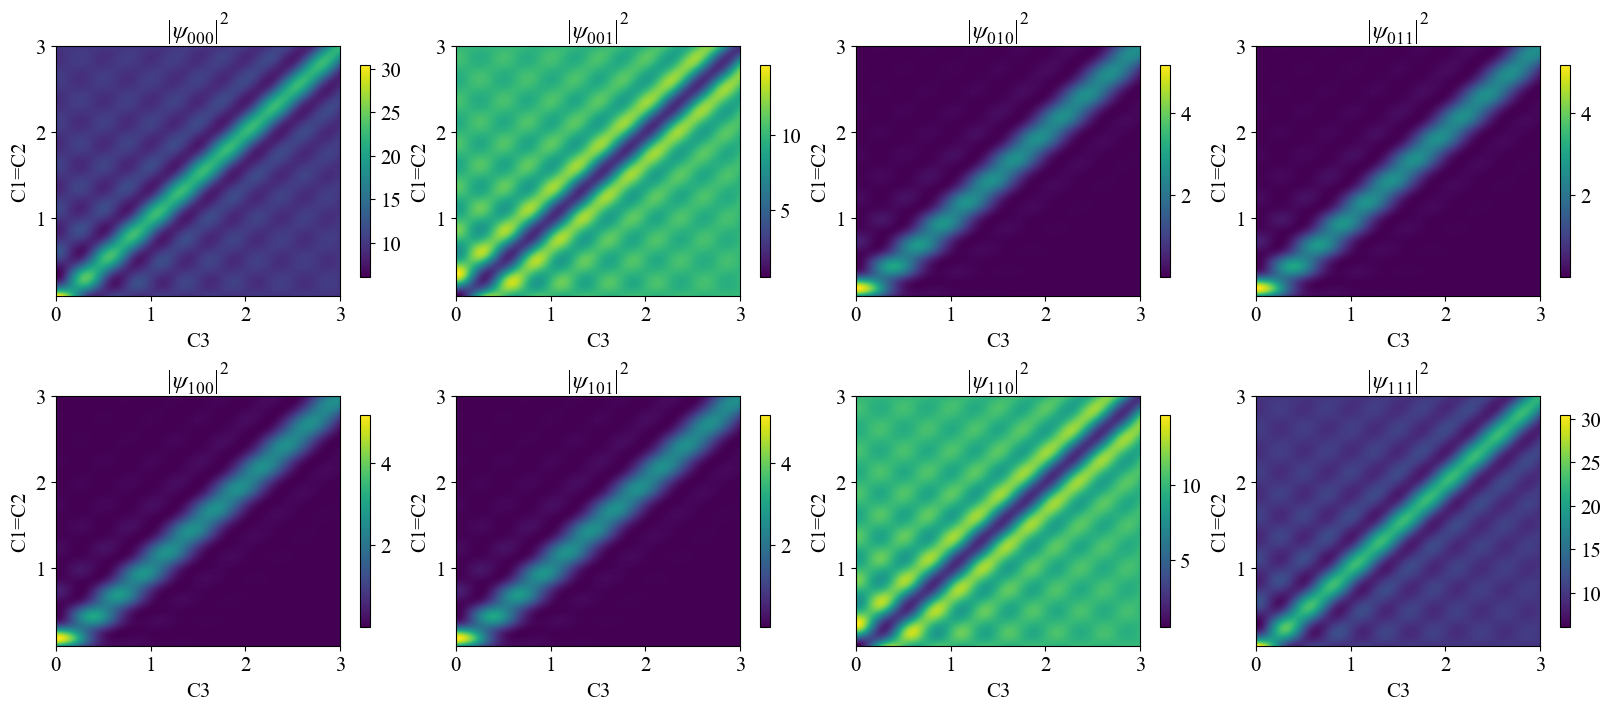

In [41]:
plot_C3_dependence(C3sweep_HBS)

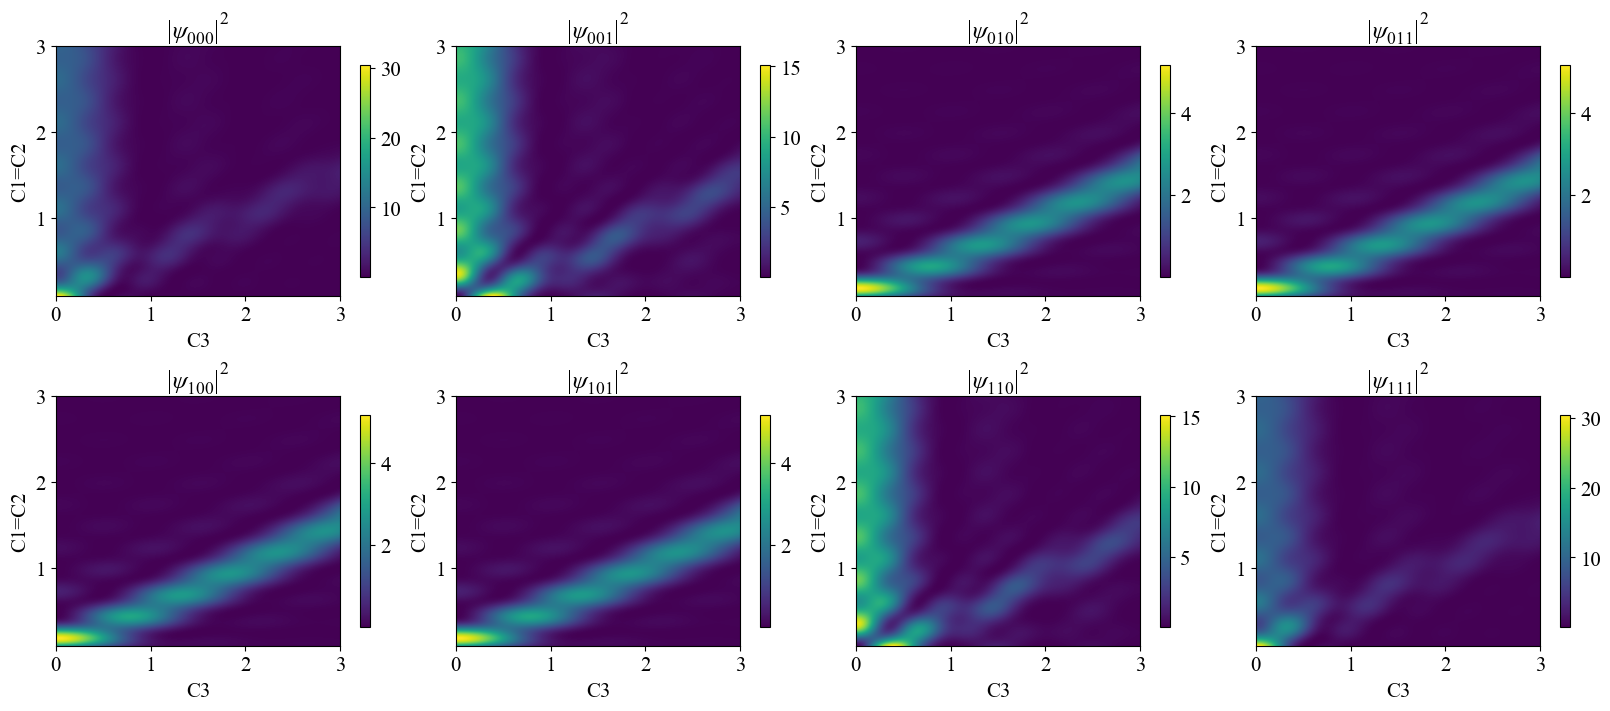

In [46]:
plot_C3_dependence(C3sweep_FS)

In [233]:
Psi_ref = C3sweep_FS.iloc[-1]
norm_fac = np.sqrt(np.sum(np.abs(Psi_ref[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']])**2))

C3_list = list(set(C3sweep_FS['C3']))
C3_list.sort()

C1_list = list(set(C3sweep_FS['C1']))
C1_list.sort()

array_2d_bell = []
array_2d_herald = []
array_2d_others = []
for C3 in C3_list:
    subdf = C3sweep_FS[C3sweep_FS['C3'] == C3]
    
    bell_state = np.array(np.square(np.abs(subdf['Psi0']/norm_fac)))
    herald_state = np.array(np.square(np.abs(subdf['Psi3']/norm_fac)))
    others = np.array(np.square(np.abs(subdf['Psi1']/norm_fac)))
    
    array_2d_bell.append(bell_state)
    array_2d_herald.append(herald_state)
    array_2d_others.append(others)



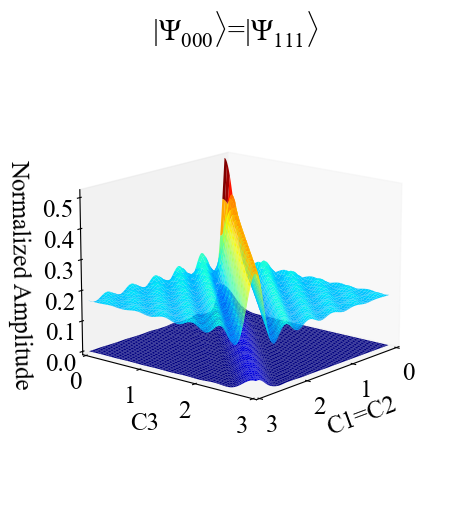

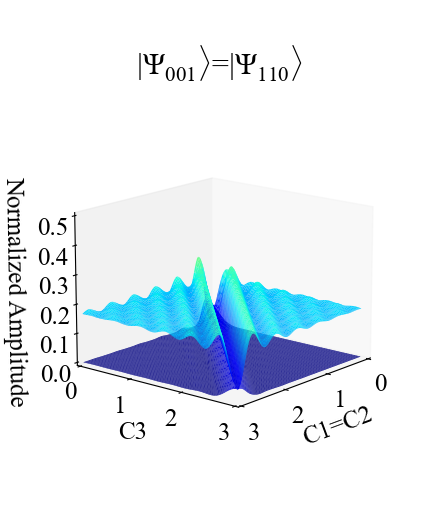

In [98]:
# Plot 3D dependence

X, Y = np.meshgrid(C1_list, C3_list)
Z_bell = np.array(array_2d_bell)
Z_herald = np.array(array_2d_herald)
Z_others = np.array(array_2d_others)

col_bell = cm.jet(Z_bell/np.amax(Z_bell))
col_herald = cm.jet(Z_herald/np.amax(Z_bell))
col_others = cm.jet(Z_others/np.amax(Z_bell))

# First subplot
fig1 = plt.figure(figsize=(5,5),layout='constrained')
ax3d = fig1.add_subplot(1, 1, 1,projection="3d")
im3d = ax3d.plot_surface(X, Y, Z_bell, cmap="plasma",rstride=5, cstride=5,linewidth=0, antialiased=True, facecolors=col_bell)
ax3d.plot_surface(X, Y, Z_others, cmap="plasma",rstride=5, cstride=5,linewidth=0, antialiased=True,facecolors=col_others)
ax3d.set_title(r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$')
ax3d.set_xlabel("\nC1=C2")
ax3d.set_ylabel("\nC3")
ax3d.set_zlabel("\nNormalized Amplitude")
ax3d.set_xlim(0,3)
ax3d.set_ylim(0,3)
#ax3d.set_zlim(0,30)
ax3d.set_xticks([0,1,2,3])
ax3d.set_yticks([0,1,2,3])
ax3d.set_zticks([0,0.1,0.2,0.3,0.4,0.5])
ax3d.view_init(elev=15, azim=40, roll=0)
ax3d.grid(False)
ax3d.set_box_aspect((1,1,0.75), zoom=0.78)
plt.show()

# Second subplot
fig2 = plt.figure(figsize=(5,5),layout='constrained')
ax3d2 = fig2.add_subplot(1, 1, 1,projection="3d")
ax3d2.plot_surface(X, Y, Z_herald, cmap="plasma",rstride=3, cstride=3,linewidth=0, antialiased=True,edgecolor=None,facecolors=col_herald)
ax3d2.plot_surface(X, Y, Z_others, cmap="plasma",rstride=3, cstride=3,linewidth=0, antialiased=True,facecolors=col_others)
plt.title('\n'+r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$')
#ax3d2.set_title(r'|$\Psi_{\{010,011,100,101\}}\rangle$')
ax3d2.set_zlabel("\nNormalized Amplitude")
ax3d2.set_xlabel("\nC1=C2")
ax3d2.set_ylabel("\nC3")
ax3d2.set_xticks([0,1,2,3])
ax3d2.set_yticks([0,1,2,3])
ax3d2.set_zticks([0,0.1,0.2,0.3,0.4,0.5])
#ax3d2.set_zlim(0,0.002)
ax3d2.set_xlim(0,3)
ax3d2.set_ylim(0,3)
ax3d2.view_init(elev=15, azim=40, roll=0)
ax3d2.grid(False)
ax3d2.set_box_aspect((1,1,0.75), zoom=0.78)
#fig2.tight_layout()                  
#fig2.subplots_adjust(top=15,bottom=10)
#plt.colorbar(im3d2, ax=ax3d2,shrink=1)

plt.show()

In [8]:
# Select Heralded Bell States
C3sweep_HBS_C1_1=C3sweep_HBS[C3sweep_HBS['C1']==1]

# Select Uniform States
C3sweep_FS_C1_1=C3sweep_FS[C3sweep_FS['C1']==1]

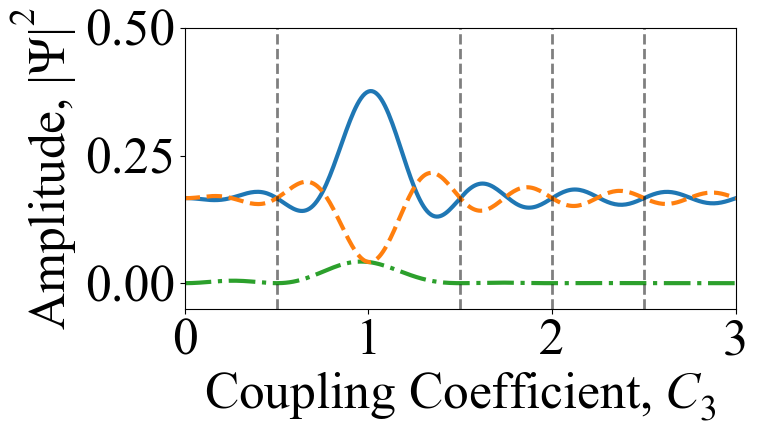

In [123]:
sub_df = C3sweep_HBS_C1_1
norm_fac = C3sweep_HBS_C1_1['NormFac'].max()
plt.figure(figsize=(8.5,5.25),layout='tight')
plt.rcParams.update({'font.size': 37})
#plt.title(r'$C_1=C_2=1$')
#plt.plot(sub_df['C3'],np.abs(sub_df['Psi1'])**2,label=r'|$\Psi_{121}\rangle$=|$\Psi_{122}\rangle$=|$\Psi_{211}\rangle$=|$\Psi_{212}\rangle$',linewidth=3)

#plt.plot(sub_df['C3'],50*np.abs(sub_df['Psi1']/norm_fac)**2,linewidth=2,alpha=0.5,color='C2',linestyle='--')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi1']/norm_fac)**2,label=r'$\Psi_{\{010,011,100,101 \}}$',linestyle='-.',linewidth=3,color='C2')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi0']/norm_fac)**2,label=r'$\Psi_{000}=\Psi_{111}$',linestyle='-',linewidth=3,color="C0")
plt.plot(sub_df['C3'],np.abs(sub_df['Psi4']/norm_fac)**2,label=r'$\Psi_{001}=\Psi_{110}$',linestyle='--',linewidth=3,color='C1')


C1=1

# Iterate over arbitrary integer m (Solution for \delBeta=-C3)
for m in [-1,1,2,3]:
    C3 = 0.5*m + C1
    if C3**2==C1**2:
        continue
    else:
        plt.axvline(C3,linestyle='--',alpha=0.5,color='k',linewidth=2)   

plt.xlim(0,3)
plt.xticks(np.arange(0,4,1))
plt.ylim(-0.05,0.5)
plt.yticks([0,0.25,0.5])



plt.xlabel(r'Coupling Coefficient, $C_3$',fontsize=37)
plt.ylabel(r'Amplitude, $|\Psi|^2$',fontsize=37)
#plt.grid()

plt.show()

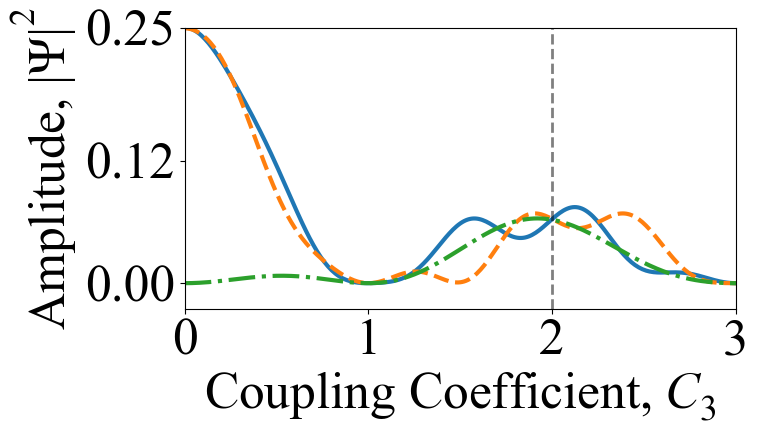

In [124]:
sub_df = C3sweep_FS_C1_1
norm_fac = C3sweep_FS_C1_1['NormFac'].max()
plt.figure(figsize=(8.5,5.25),layout='tight')
plt.rcParams.update({'font.size': 37})
#plt.title(r'$C_1=C_2=1$')
#plt.plot(sub_df['C3'],np.abs(sub_df['Psi1'])**2,label=r'|$\Psi_{121}\rangle$=|$\Psi_{122}\rangle$=|$\Psi_{211}\rangle$=|$\Psi_{212}\rangle$',linewidth=3)

#plt.plot(sub_df['C3'],50*np.abs(sub_df['Psi1']/norm_fac)**2,linewidth=2,alpha=0.5,color='C2',linestyle='--')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi0']/norm_fac)**2,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linestyle='-',linewidth=3,color='C0')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi4']/norm_fac)**2,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linestyle='--',linewidth=3,color='C1')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi1']/norm_fac)**2,label=r'|$\Psi_{\{010,011,100,101 \}}\rangle$',linestyle='-.',linewidth=3,color='C2')
plt.axvline(2,linestyle='--',alpha=0.5,color='k',linewidth=2)   

plt.xlim(0,3)
plt.ylim(-0.025,0.25)
plt.yticks([0,0.12,0.25])
plt.xticks(np.arange(0,4,1))
"""
plt.legend(fontsize=35,
           ncols=1,
           bbox_to_anchor=(0.5,1),
           alignment='center',
           loc='lower center',
           labelspacing=0,
           columnspacing=0,
           framealpha=0.5)
"""
plt.xlabel(r'Coupling Coefficient, $C_3$',fontsize=37)
plt.ylabel(r'Amplitude, $|\Psi|^2$',fontsize=37)
#plt.grid()

plt.show()


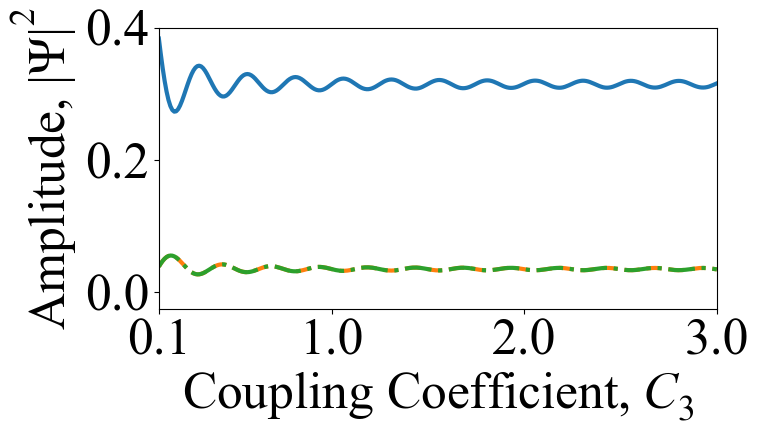

In [127]:
#example_GHZ = calc_wfcn(1, 1, 1)
sub_df = C3sweep_GHZ_1 = C3sweep_HBS[(C3sweep_HBS['delBeta']==-C3sweep_HBS['C3']) & (C3sweep_HBS['C3']==C3sweep_HBS['C1'])]
norm_fac = sub_df['NormFac'].max()
plt.figure(figsize=(8.5,5.25),layout='tight')
plt.rcParams.update({'font.size': 37})
#plt.title(r'$C_1=C_2=1$')
#plt.plot(sub_df['C3'],np.abs(sub_df['Psi1'])**2,label=r'|$\Psi_{121}\rangle$=|$\Psi_{122}\rangle$=|$\Psi_{211}\rangle$=|$\Psi_{212}\rangle$',linewidth=3)

#plt.plot(sub_df['C3'],50*np.abs(sub_df['Psi1']/norm_fac)**2,linewidth=2,alpha=0.5,color='C2',linestyle='--')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi0']/norm_fac)**2,label=r'|$\Psi_{000}\rangle$=|$\Psi_{111}\rangle$',linestyle='-',linewidth=3,color='C0')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi4']/norm_fac)**2,label=r'|$\Psi_{001}\rangle$=|$\Psi_{110}\rangle$',linestyle='--',linewidth=3,color='C1')
plt.plot(sub_df['C3'],np.abs(sub_df['Psi1']/norm_fac)**2,label=r'|$\Psi_{\{010,011,100,101 \}}\rangle$',linestyle='-.',linewidth=3,color='C2')
plt.axvline(-1,linestyle='--',alpha=0.5,color='k',linewidth=2)   

plt.xlim(0.1,3)
plt.ylim(-0.025,0.4)
plt.yticks([0,0.2,0.4])
plt.xticks([0.1,1,2,3])
#plt.legend(fontsize=19,loc='best')
plt.xlabel(r'Coupling Coefficient, $C_3$',fontsize=37)
plt.ylabel(r'Amplitude, $|\Psi|^2$',fontsize=37)
#plt.grid()

plt.show()


## Plot Density Matrix

In [252]:
def calc_wfcn(init_C1, init_C2, C3):
    n_photon = 3
    n_wg = 2

    # C3 = 0.1
    # init_C1 = 0.1
    # init_C2 = 0.1
    max_z = 2*np.pi
    zs=np.linspace(0,max_z,100)
    zs=[max_z]

    init_gamma = 1
    init_del_beta = 0
    init_del_phi = 0


    Ez0 = [1 + 0j, 1 + 0j] 
    Psi0 = [0] * (n_wg**n_photon)
    Ez_Psi0 = Ez0 + Psi0

    #delBeta_range = np.linspace(-1.8,1.8,50)
    #delPhi_range = np.arange(-2*3.14,2*3.14+0.01,0.01)
    delBeta_range = np.arange(-2*3.14,2*3.14+0.01,0.01)

    df_list= [] 
    #for delBeta in delBeta_range:
    for delBeta in delBeta_range:
        Ez_Psi = solve_ivp(coupled_SPDC_dEz_dz_dPsi_dz
                            , [0, max_z]
                            , Ez_Psi0
                            # , max_step=max_step_z  # comment out if the "t_eval=" is specified
                            , t_eval=zs
                            , dense_output=True
                            , args=(init_C1, init_C2, C3, init_gamma, delBeta, 0)) 

        data = pd.DataFrame(Ez_Psi.y.transpose(),columns=['Ez1','Ez2','Psi0','Psi1','Psi2','Psi3','Psi4','Psi5','Psi6','Psi7'])
        data['z']=Ez_Psi.t
        data.insert(0, 'z', data.pop('z')) 

        Psi = data[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']]
        Psi = np.array(Psi)
        norm_fac = np.sqrt(np.sum(np.abs(Psi)**2))

        # Include metadata
        data['NormFac'] = norm_fac
        data['C1'] = init_C1
        data['C2'] = init_C2
        data['C3'] = C3
        data['Gamma'] = init_gamma
        data['delBeta'] = round(delBeta,3)
        data['delPhi'] = 0
        df_list.append(data)

    main_df = pd.concat(df_list)
    return main_df

In [179]:
example_HBS = calc_wfcn(1, 1, 2,-2)
example_FS = calc_wfcn(1, 1, 2,0)
example_GHZ = calc_wfcn(0.1, 0.1, 0.1, 0)

In [195]:
Psi_norm = np.array(main_df[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']].iloc[0])/main_df['NormFac'].iloc[0]
den_mat = np.outer(Psi_norm,Psi_norm)
den_mat_real = np.outer(Psi_norm,Psi_norm).real
den_mat_real = np.savetxt('den_mat_real_GHZ_C1=C2=C31_C3=0.1.csv', den_mat_real, delimiter = ",")

In [247]:
def plot_density_matrix(main_df):
    plt.rcParams.update({'font.size': 18})
    states = ['000','010','100','110','001','011','101','111']
    Psi_norm = np.array(main_df[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']].iloc[0])/main_df['NormFac'].iloc[0]
    den_mat = np.outer(Psi_norm,Psi_norm)
    den_mat_real = np.outer(Psi_norm,Psi_norm).real
    plt.imshow(den_mat_real,cmap='bwr')
    plt.xticks([0,1,2,3,4,5,6,7],labels=states,rotation=45)
    plt.yticks([0,1,2,3,4,5,6,7],labels=states)
    plt.xlabel(r'|$\Psi\rangle$')
    plt.ylabel(r'|$\Psi\rangle$')
    plt.colorbar(label=r'|$\Psi\rangle \langle \Psi| $')
    plt.show()
    
def plot_density_matrix_imag(main_df):
    states = ['000','010','100','110','001','011','101','111']
    Psi_norm = np.array(main_df[['Psi0', 'Psi1', 'Psi2', 'Psi3', 'Psi4', 'Psi5', 'Psi6', 'Psi7']].iloc[0])/main_df['NormFac'].iloc[0]
    den_mat = np.outer(Psi_norm,Psi_norm)
    den_mat_real = np.outer(Psi_norm,Psi_norm).imag
    plt.imshow(den_mat_real,cmap='bwr')
    plt.xticks([0,1,2,3,4,5,6,7],labels=states,rotation=45)
    plt.yticks([0,1,2,3,4,5,6,7],labels=states)
    plt.xlabel(r'|$\Psi\rangle$')
    plt.ylabel(r'|$\Psi\rangle$')
    plt.colorbar(label=r'|$\Psi\rangle \langle \Psi| $')
    plt.show()

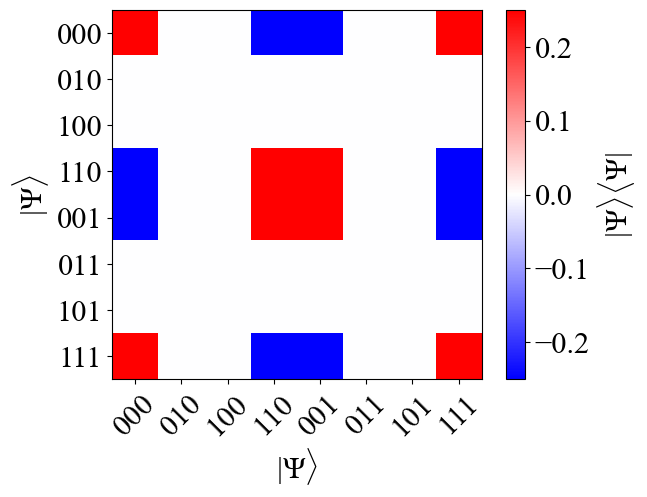

In [186]:
plot_density_matrix(example_HBS)

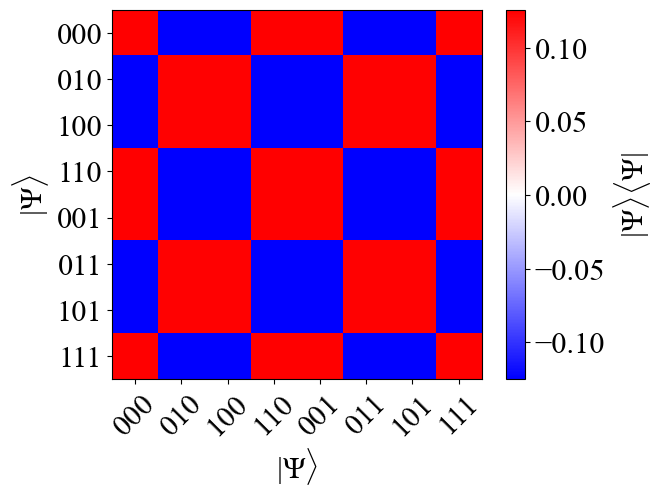

In [187]:
plot_density_matrix(example_FS)

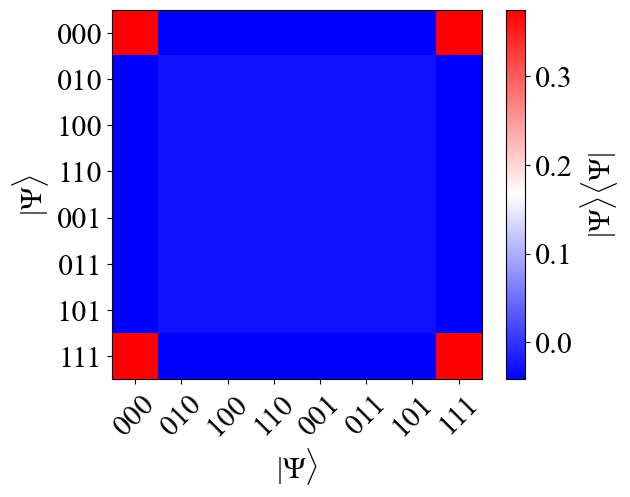

In [188]:
plot_density_matrix(example_GHZ)

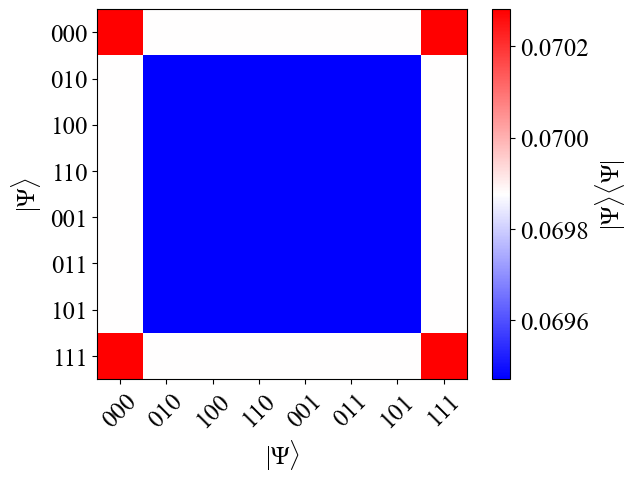

In [248]:
plot_density_matrix(calc_wfcn(1, 1, 1, 0))

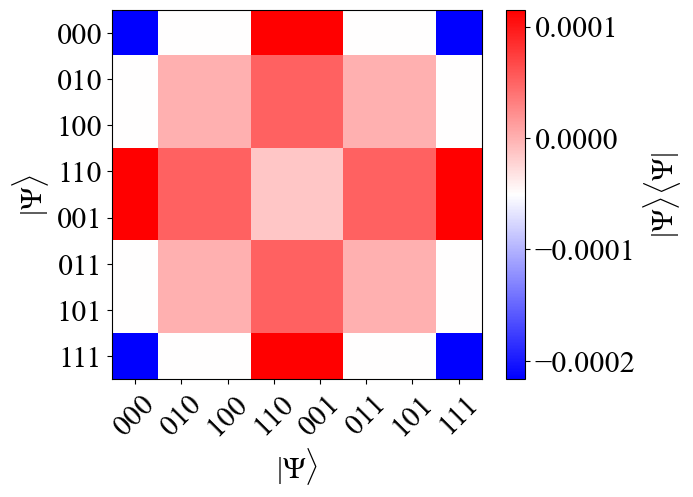

In [197]:
plot_density_matrix_imag(example_HBS)

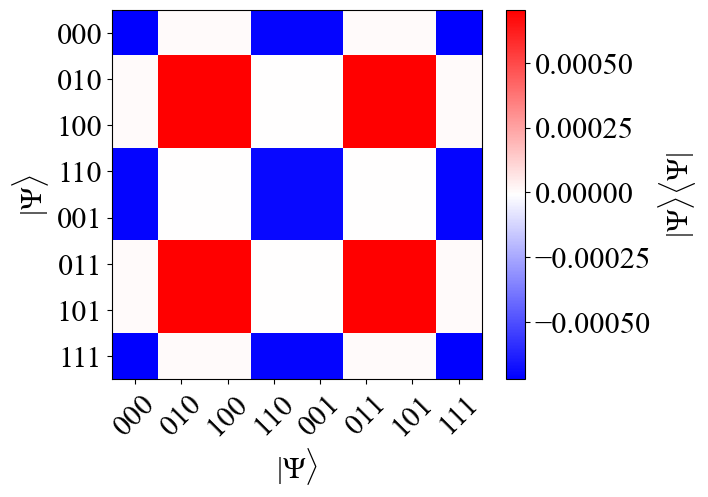

In [198]:
plot_density_matrix_imag(example_FS)

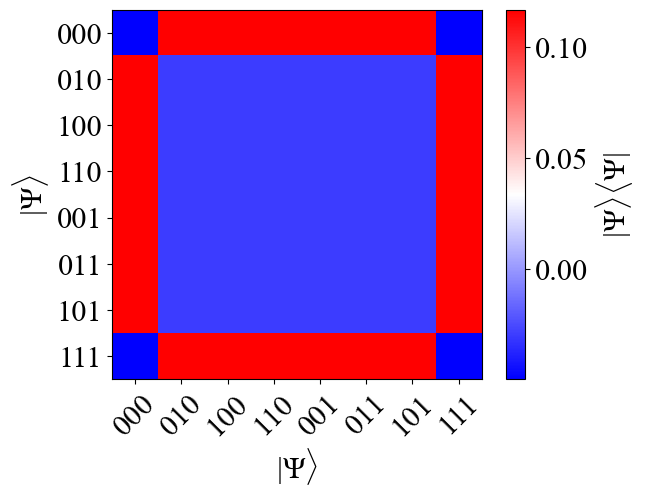

In [199]:
plot_density_matrix_imag(example_GHZ)